## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 2

A single tile of approximately 1x1 degree is used to show the GSKY layer. No further analysis of the data is performed.

Instead of writing the GSKY output into a NetCDF file and then reading it back into Xarray, this example uses the **diskless** NetCDF that eliminates the disk I/O. Though it is quite unnecessary to do so in a single datafile situation, it is nevertheless given here to demonstrate the capability.

The data is in **netCDF4.\_netCDF4.Dataset** format. A drawback of plotting the values directly from it is that only one band per image can be plotted (cf. three bands together when using Xarray). Converting the in-memory data into Xarray Dataset does not work.

###### Specifics

- Converting a DEA notebook example to use GSKY instead of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 17 December, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a tile by its ID (e.g. 8_-31).

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment a code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use (from 0 to n_times-1).

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 14/01/2020  #
##########################################################

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import logging, sys
logging.disable(sys.maxsize)


#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
# for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

#### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1

# The time slice whose data is to be displayed is specified below. 
t = 1

# Uncomment below to see all available times.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])


#### The Australian continent is divided into approximately 1x1 degree tiles, from -22 to +27 longitude degrees from a line through the centre of Australia.

The ID and BBox for each tile will be generated in the next box. Choose a tile by its ID to display the layer.

In [4]:
tiles_list = {}
with open("tiles_bboxes_out.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and their BBoxes
# tiles_list

#### You must select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time.

If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below. There should not be any space in the array of values.


In [5]:
tiles = ['6_-31']
bbox = [tiles_list[tiles[0]]]

# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))
bbox = (x,y,X,Y)
bbox

(138.15, -27.48, 139.59, -28.41)

### Construct the GSKY end point URL and send to the GSKY server

The GSKY capability endpoint URL is constructed below. You must specify a style ('fc' or 'tc'). In this example we are retrieving and plotting the True Color (tc).

#### DO NOT write the data into a file

The GSKY server returns the data in NetCDF format which is read into the variable, nc, in memory. It is NOT written to the disk.

In [6]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This notebook uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())

# Uncomment next line to see the URL sent to the GSKY server.
# print(output.geturl())

### Stack the bands together and plot it
To plot the bands together, as in the case of Xarray, it is necessary to stack them using numpy. 

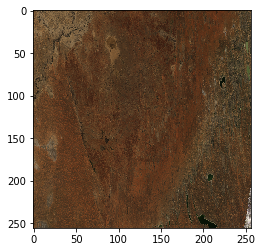

In [7]:
r = nc.variables['Band1'][:]
g = nc.variables['Band2'][:]
b = nc.variables['Band3'][:]
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
rgb = np.stack([r, g, b], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()

### Plot the individual bands

You can plot the individual bands as well. It is not necessary to stack these or convert to float32

<function matplotlib.pyplot.show(*args, **kw)>

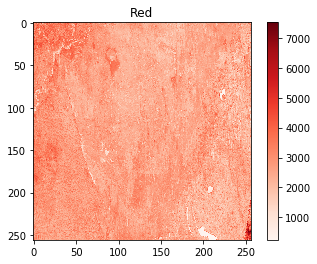

In [8]:
plt.imshow(r, cmap='Reds')
plt.title('Red')
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

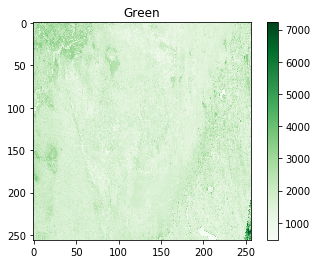

In [9]:
plt.imshow(g, cmap = 'Greens')
plt.title('Green')
plt.colorbar()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

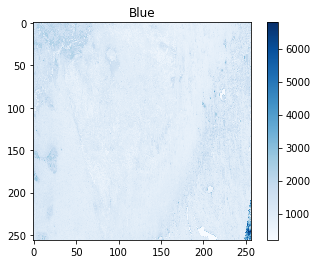

In [10]:
plt.imshow(b, cmap = 'Blues')
plt.colorbar()
plt.title('Blue')
plt.show

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`